In [1]:
# General packages
import pandas as pd
import numpy as np
import re 
import os
import gc
import math
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()
import datetime
import warnings
warnings.filterwarnings('ignore')

# Data vis packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data prep
import cv2
import imgaug.augmenters as iaa

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics

np.random.seed(14)

# Modelling packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as k
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, LeakyReLU,Convolution2D, concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import Callback, EarlyStopping, LearningRateScheduler

from sklearn.model_selection import KFold


# Data access
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)

## 2.00 Read Data

The way the repository is set out is shown below:

`
+--input
|  +--images
|     +--Test_0.jpg
|     +--Train_0.jpg
|     +--...
|  +--sample_submission.csv
|  +--test.csv
|  +--train.csv
+--output
`

In [2]:
# Define paths - pp stands for plant pathology
input_path = '../input'
pp_dir_path = os.path.join(input_path, 'plant-pathology-2020-fgvc7')

train_metadata_path = os.path.join(pp_dir_path, 'train.csv')
test_metadata_path = os.path.join(pp_dir_path, 'test.csv')
sample_sub_path = os.path.join(pp_dir_path, 'sample_submission.csv')

img_dir_path = os.path.join(pp_dir_path, 'images/')

# List img_dir
img_dir = os.listdir(img_dir_path)
img_dir_train = [string for string in img_dir if 'Train' in string]
img_dir_test = [string for string in img_dir if 'Test' in string]

# Read train, test metadata
train_metadata = pd.read_csv(train_metadata_path)
test_metadata = pd.read_csv(test_metadata_path)

# Read sample submission
sample_sub = pd.read_csv(sample_sub_path)

In [3]:
ROWS = 768
COLS = 768
CHANNELS = 3
CLASSES = 4

EPOCHS = 70
BATCH_SIZE = 8

In [4]:
# Read images in
img_list = []
filenames = train_metadata.image_id

for file in tqdm(filenames):
    image = cv2.imread(img_dir_path + file + '.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    res = cv2.resize(image,(ROWS,COLS))
    img_list.append(res)
    
X_train = np.array(img_list)

100%|██████████| 1821/1821 [00:37<00:00, 48.81it/s]


In [5]:
X_train.shape

(1821, 768, 768, 3)

In [6]:
y_train = np.array(train_metadata.drop('image_id', axis=1))
del [img_list, filenames]

## 3.00 Data Augmentation


In [7]:
aug_pipeline = iaa.Sequential([
    iaa.Sometimes(0.5, 
                  iaa.GaussianBlur((0, 10.0)) # apply Gaussian blur with a sigma between 0 and 10 to 50% of the images
                 ),
    iaa.SomeOf((0, 3),[
        iaa.Fliplr(1.0), # Horizontal flip
        iaa.Affine(rotate=25), # Rotate 50% of the images
        iaa.AffineCv2(translate_px=16), # Zoom in
        iaa.AdditiveGaussianNoise(20),
        iaa.JpegCompression(compression=(70, 99)),
    ])
],
random_order=True # apply the augmentations in random order
)

In [8]:
X_train_aug = []
for img in tqdm(X_train):
    img_aug = aug_pipeline.augment_image(img)
    X_train_aug.append(img_aug)
    
X_train_aug = np.asarray(X_train_aug)

# Shuffle train data
X_train_aug, y_train = shuffle(X_train_aug, y_train, random_state=14)
X_train_aug.shape

100%|██████████| 1821/1821 [00:21<00:00, 84.25it/s] 


(1821, 768, 768, 3)

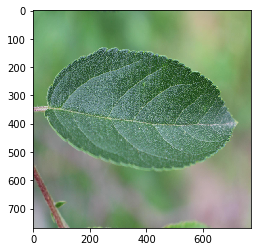

In [9]:
plt.imshow(X_train_aug[np.random.randint(0,len(X_train_aug))])

Learning rate schedule: 0.0001 to 0.00011 to 1e-06


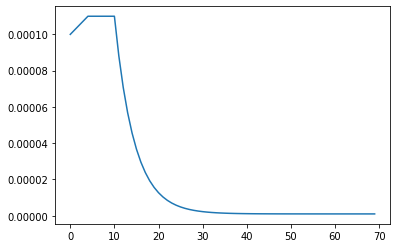

In [10]:
strategy = tf.distribute.get_strategy()

LR_START = 0.0001
LR_MAX = 0.00011
LR_MIN = 0.000001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 6
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [11]:
X_train_aug.shape

(1821, 768, 768, 3)

## 4.00 Modelling
### 4.01 ResNet50

In [12]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [13]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [14]:
def ResNet50(input_shape = (ROWS, COLS, CHANNELS), classes = CLASSES):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL.
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

#### Train Model

In [15]:
k.clear_session()

kfolds = 4
kf = KFold(n_splits=kfolds)
rocauc_scores = []

for fold, (tdx, vdx) in enumerate(kf.split(X_train_aug, y_train)):
    print(f'Fold : {fold}')
    X, X_val, y, y_val = X_train_aug[tdx], X_train_aug[vdx], y_train[tdx], y_train[vdx]
    model = ResNet50(input_shape=(ROWS, COLS, CHANNELS), classes=CLASSES)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    es = EarlyStopping(monitor='loss', 
                   mode='min',
                   restore_best_weights=True, 
                   verbose=2, 
                   patience=7)

    lr = LearningRateScheduler(lrfn, verbose=1)

    model.fit(X, y, callbacks=[es, lr], epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
    
    pred = model.predict([X_val])
    #pred = np.argmax(pred, axis=1) # removed to fit with rocauc score. Uncomment for accuracy score
    #y_val = np.argmax(y_val, axis=1) # removed to fit with rocauc score. Uncomment for accuracy score

    oof_rocauc = metrics.roc_auc_score(y_val, pred)
    model.save_weights(f'resnet50_{fold}.h5')
    print('')
    print('\nFold ' + str(fold) + ' ROCAUC: ' + str(oof_rocauc))
    print('')
    rocauc_scores.append(oof_rocauc)
    gc.collect()
    

Fold : 0
Train on 1365 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/70
1365/1365 [==============================] - 69s 51ms/sample - loss: 6.7003 - accuracy: 0.3033

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001025.
Epoch 2/70
1365/1365 [==============================] - 62s 45ms/sample - loss: 2.7212 - accuracy: 0.4564

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000105.
Epoch 3/70
1365/1365 [==============================] - 62s 45ms/sample - loss: 1.6428 - accuracy: 0.6029

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00010750000000000001.
Epoch 4/70
1365/1365 [==============================] - 62s 46ms/sample - loss: 1.2250 - accuracy: 0.6777

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00011.
Epoch 5/70
1365/1365 [==============================] - 62s 46ms/sample - loss: 1.0249 - accuracy: 0.6960

Epoch 00006: LearningRateScheduler reducing learning rate to 0.000

1366/1366 [==============================] - 62s 46ms/sample - loss: 0.9467 - accuracy: 0.6991

Epoch 00006: LearningRateScheduler reducing learning rate to 0.00011.
Epoch 6/70
1366/1366 [==============================] - 62s 46ms/sample - loss: 0.8120 - accuracy: 0.7299

Epoch 00007: LearningRateScheduler reducing learning rate to 0.00011.
Epoch 7/70
1366/1366 [==============================] - 62s 46ms/sample - loss: 0.6722 - accuracy: 0.7665

Epoch 00008: LearningRateScheduler reducing learning rate to 0.00011.
Epoch 8/70
1366/1366 [==============================] - 62s 46ms/sample - loss: 0.7570 - accuracy: 0.7804

Epoch 00009: LearningRateScheduler reducing learning rate to 0.00011.
Epoch 9/70
1366/1366 [==============================] - 62s 46ms/sample - loss: 0.8150 - accuracy: 0.7716

Epoch 00010: LearningRateScheduler reducing learning rate to 0.00011.
Epoch 10/70
1366/1366 [==============================] - 62s 46ms/sample - loss: 0.6184 - accuracy: 0.8097

Epoch 00011: Learn

1366/1366 [==============================] - 62s 46ms/sample - loss: 0.0025 - accuracy: 1.0000

Epoch 00049: LearningRateScheduler reducing learning rate to 1.022638414303212e-06.
Epoch 49/70
1366/1366 [==============================] - 62s 46ms/sample - loss: 0.0018 - accuracy: 0.9993

Epoch 00050: LearningRateScheduler reducing learning rate to 1.0181107314425695e-06.
Epoch 50/70
1366/1366 [==============================] - 62s 46ms/sample - loss: 0.0018 - accuracy: 1.0000

Epoch 00051: LearningRateScheduler reducing learning rate to 1.0144885851540556e-06.
Epoch 51/70
1366/1366 [==============================] - 62s 46ms/sample - loss: 0.0026 - accuracy: 1.0000

Epoch 00052: LearningRateScheduler reducing learning rate to 1.0115908681232445e-06.
Epoch 52/70
1366/1366 [==============================] - 62s 46ms/sample - loss: 0.0017 - accuracy: 1.0000

Epoch 00053: LearningRateScheduler reducing learning rate to 1.0092726944985956e-06.
Epoch 53/70
1366/1366 [=========================

1366/1366 [==============================] - 62s 45ms/sample - loss: 0.0197 - accuracy: 0.9941

Epoch 00023: LearningRateScheduler reducing learning rate to 8.490422964224005e-06.
Epoch 23/70
1366/1366 [==============================] - 62s 45ms/sample - loss: 0.0102 - accuracy: 0.9978

Epoch 00024: LearningRateScheduler reducing learning rate to 6.992338371379204e-06.
Epoch 24/70
1366/1366 [==============================] - 62s 45ms/sample - loss: 0.0084 - accuracy: 0.9985

Epoch 00025: LearningRateScheduler reducing learning rate to 5.793870697103364e-06.
Epoch 25/70
1366/1366 [==============================] - 62s 45ms/sample - loss: 0.0115 - accuracy: 0.9978

Epoch 00026: LearningRateScheduler reducing learning rate to 4.835096557682691e-06.
Epoch 26/70
1366/1366 [==============================] - 62s 45ms/sample - loss: 0.0076 - accuracy: 0.9985

Epoch 00027: LearningRateScheduler reducing learning rate to 4.068077246146153e-06.
Epoch 27/70
1366/1366 [=============================

1366/1366 [==============================] - 62s 45ms/sample - loss: 0.0180 - accuracy: 0.9963

Epoch 00019: LearningRateScheduler reducing learning rate to 1.928716544000001e-05.
Epoch 19/70
1366/1366 [==============================] - 62s 45ms/sample - loss: 0.0180 - accuracy: 0.9941

Epoch 00020: LearningRateScheduler reducing learning rate to 1.5629732352000006e-05.
Epoch 20/70
1366/1366 [==============================] - 62s 46ms/sample - loss: 0.0079 - accuracy: 1.0000

Epoch 00021: LearningRateScheduler reducing learning rate to 1.2703785881600007e-05.
Epoch 21/70
1366/1366 [==============================] - 62s 45ms/sample - loss: 0.0158 - accuracy: 0.9949

Epoch 00022: LearningRateScheduler reducing learning rate to 1.0363028705280007e-05.
Epoch 22/70
1366/1366 [==============================] - 62s 45ms/sample - loss: 0.0303 - accuracy: 0.9919

Epoch 00023: LearningRateScheduler reducing learning rate to 8.490422964224005e-06.
Epoch 23/70
1366/1366 [==========================

In [16]:
print(f'Mean OOF ROCAUC: {np.mean(rocauc_scores)}')

Mean OOF ROCAUC: 0.8494029336158669


### 4.02 DenseNet

In [ ]:
def bn_relu_convolution(x, nb_channels, dropout_rate=None, bottleneck=False, weight_decay=1e-4):
    """
    Creates convolution layers consisting of BN-ReLU-Conv.
    Optional: bottleneck, dropout
    
    """
    # Bottleneck
    if bottleneck:
        bottleneckWidth = 4
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(nb_channels * bottleneckWidth, (1, 1),
                          kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
        # Dropout
        if dropout_rate:
            x = layers.Dropout(dropout_rate)(x)

    # BN-ReLU-Conv
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_channels, (3, 3), padding='same')(x)

    # Dropout
    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x

In [ ]:
def bn_relu_transition(x, nb_channels, dropout_rate=None, compression=1.0, weight_decay=1e-4):
    """
    Creates a transition layer between dense blocks as transition, which do convolution and pooling.
    Works as downsampling.
    """

    x = BatchNormalization()(x)
    x = Activation('relu',)(x)
    x = Convolution2D(int(nb_channels * compression), (1, 1), padding='same',
                             kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)

    # Adding dropout
    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    x = AveragePooling2D((2, 2), strides=(2, 2))(x)
    return x

In [ ]:
def dense_block(x, num_layers, nb_channels, growth_rate, dropout_rate=None, bottleneck=False,
                    weight_decay=1e-4):
    """
    Creates a dense block and concatenates inputs
    """

    for i in range(num_layers):
        cb = bn_relu_convolution(x, growth_rate, dropout_rate, 
                                 bottleneck) # 1 conv if bottleneck = 0 else 2 conv if bottleneck = 1
        nb_channels += growth_rate
        x = concatenate([cb, x])
    return x, nb_channels

In [ ]:
def DenseNet(input_shape, dense_blocks, dense_layers, growth_rate, compression, bottleneck, 
                     weight_decay, dropout_rate, num_classes, ):
        """
        Build the model
        Returns: tf Keras Model instance
        """

        # Input Layer
        img_input = Input(shape=input_shape, name = 'img_input')
        nb_channels = growth_rate

        # Input-convolution layer
        x = Conv2D(2 * growth_rate, (3, 3), padding='same', strides=(1, 1),name='input_conv', 
                          kernel_regularizer= tf.keras.regularizers.l2(weight_decay))(img_input)

        # Building dense blocks
        for block in range(dense_blocks - 1):
            # Add dense_block
            x, nb_channels = dense_block(x, dense_layers[block], nb_channels, growth_rate,
                                     dropout_rate, bottleneck, weight_decay) 

            # Add transition
            x = bn_relu_transition(x, nb_channels, dropout_rate, compression, weight_decay) # 1 conv layer
            nb_channels = int(nb_channels * compression)

        # Add last dense block without transition but with only global average pooling
        x, nb_channels = dense_block(x, dense_layers[-1], nb_channels,
                                          growth_rate, dropout_rate, weight_decay)
        
        # prediction of class happens here
        x = BatchNormalization(name = 'prediction_bn')(x)
        x = Activation('relu',  name = 'prediction_relu', )(x)
        x = GlobalAveragePooling2D( name = 'prediction_pool', )(x)
        prediction = Dense(num_classes, name = 'prediction_dense', activation='softmax')(x)

        return tf.keras.Model(inputs=img_input, outputs=prediction, name='densenet')

#### Train Model

In [ ]:
k.clear_session()

kfolds = 5
kf = KFold(n_splits=kfolds)
rocauc_scores = []

for fold, (tdx, vdx) in enumerate(kf.split(X_train, y_train)):
    print(f'Fold : {fold}')
    X, X_val, y, y_val = X_train[tdx], X_train[vdx], y_train[tdx], y_train[vdx]
    model = DenseNet(input_shape=(ROWS,COLS,CHANNELS), dense_blocks=3, dense_layers=[16]*3,
                         growth_rate=12, compression=0.5, num_classes=CLASSES, bottleneck=True, 
                         dropout_rate=None, weight_decay=1e-5)    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    es = EarlyStopping(monitor='loss', 
                   mode='min',
                   restore_best_weights=True, 
                   verbose=2, 
                   patience=5)
    
    lr = LearningRateScheduler(lrfn, verbose=1)

    model.fit(X, y, callbacks=[es, lr], epochs=EPOCHS, batch_size=8, verbose=1)
    
    pred = model.predict([X_val])
    #pred = np.argmax(pred, axis=1)
    #y_val = np.argmax(y_val, axis=1)

    oof_rocauc = metrics.roc_auc_score(y_val, pred)
    model.save_weights(f'densenet{fold}.h5')
    print('')
    print('Fold ' + str(fold) + ' ROCAUC: ' + str(oof_rocauc))
    print('')
    rocauc_scores.append(oof_rocauc)
    gc.collect()

In [ ]:
print(f'Mean OOF Accuracy: {np.mean(accuracy_scores)}')

## 6.00 Make Submission
### 6.01 Prepare Test Data

In [17]:
# Import all ResNet models
models = []
for i in range(kfolds):
    model = ResNet50(input_shape=(ROWS, COLS, CHANNELS), classes=CLASSES)
    model.load_weights(f'../output/resnet50_{i}.h5')
    models.append(model)

In [ ]:
# Import all DenseNet models
models = []
for i in range(kfolds):
    model = DenseNet(input_shape=(ROWS,COLS,CHANNELS), dense_blocks=3, dense_layers=[16]*3,
                     growth_rate=12, compression=0.5, num_classes=CLASSES, bottleneck=True, 
                     dropout_rate=None, weight_decay=1e-5)    
    model.load_weights(f'../output/densenet{i}.h5')
    models.append(model)

In [18]:
# Read images in
img_list = []
filenames = test_metadata.image_id

for file in tqdm(filenames):
    image = cv2.imread(img_dir_path + file + '.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    res = cv2.resize(image,(ROWS,COLS))
    img_list.append(res)
    
X_test = np.array(img_list)

100%|██████████| 1821/1821 [00:35<00:00, 50.96it/s]


In [19]:
# Make predictions on test data
preds_test = np.mean([model.predict(X_test) for model in models], axis=0)

# Create dataframe for test preds
preds_test_df = pd.DataFrame(preds_test, columns=train_metadata.columns[1:5])
# Update submission df with results
sample_sub.update(preds_test_df)
sample_sub.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,2.905017e-13,1.287297e-09,1.000000,3.467770e-14
1,Test_1,5.447045e-11,2.601670e-08,1.000000,2.124456e-07
2,Test_2,6.815110e-04,3.184077e-03,0.000009,9.961254e-01
3,Test_3,8.439662e-01,2.324446e-06,0.000812,1.552191e-01
4,Test_4,0.000000e+00,2.732562e-22,1.000000,7.214151e-38


In [20]:
sample_sub.to_csv("submission.csv", index=False)

In [ ]:
model_info = """

ROWS = 768
COLS = 768
CHANNELS = 3
CLASSES = 4

EPOCHS = 70
BATCH_SIZE = 8


# Read images in
img_list = []
filenames = train_metadata.image_id

for file in tqdm(filenames):
    image = cv2.imread(img_dir_path + file + '.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    res = cv2.resize(image,(ROWS,COLS))
    img_list.append(res)
    
X_train = np.array(img_list)

y_train = np.array(train_metadata.drop('image_id', axis=1))
del [img_list, filenames]

aug_pipeline = iaa.Sequential([
    iaa.Sometimes(0.5, 
                  iaa.GaussianBlur((0, 10.0)) # apply Gaussian blur with a sigma between 0 and 10 to 50% of the images
                 ),
    iaa.SomeOf((0, 3),[
        iaa.Fliplr(1.0), # Horizontal flip
        iaa.Affine(rotate=25), # Rotate 50% of the images
        iaa.AffineCv2(translate_px=16), # Zoom in
        iaa.AdditiveGaussianNoise(20),
        iaa.JpegCompression(compression=(70, 99)),
    ])
],
random_order=True # apply the augmentations in random order
)

X_train_aug = []
for img in tqdm(X_train):
    img_aug = aug_pipeline.augment_image(img)
    X_train_aug.append(img_aug)
    
X_train_aug = np.asarray(X_train_aug)

# Shuffle train data
X_train_aug, y_train = shuffle(X_train_aug, y_train, random_state=14)
X_train_aug.shape

strategy = tf.distribute.get_strategy()

LR_START = 0.0001
LR_MAX = 0.00011
LR_MIN = 0.000001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 6
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def ResNet50(input_shape = (ROWS, COLS, CHANNELS), classes = CLASSES):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL.
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model


k.clear_session()

kfolds = 6
kf = KFold(n_splits=kfolds)
rocauc_scores = []

for fold, (tdx, vdx) in enumerate(kf.split(X_train_aug, y_train)):
    print(f'Fold : {fold}')
    X, X_val, y, y_val = X_train_aug[tdx], X_train_aug[vdx], y_train[tdx], y_train[vdx]
    model = ResNet50(input_shape=(ROWS, COLS, CHANNELS), classes=CLASSES)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    es = EarlyStopping(monitor='loss', 
                   mode='min',
                   restore_best_weights=True, 
                   verbose=2, 
                   patience=7)

    lr = LearningRateScheduler(lrfn, verbose=1)

    model.fit(X, y, callbacks=[es, lr], epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
    
    pred = model.predict([X_val])
    #pred = np.argmax(pred, axis=1) # removed to fit with rocauc score. Uncomment for accuracy score
    #y_val = np.argmax(y_val, axis=1) # removed to fit with rocauc score. Uncomment for accuracy score

    oof_rocauc = metrics.roc_auc_score(y_val, pred)
    model.save_weights(f'resnet50_{fold}.h5')
    print('')
    print('\nFold ' + str(fold) + ' ROCAUC: ' + str(oof_rocauc))
    print('')
    rocauc_scores.append(oof_rocauc)
    gc.collect()
    

"""

In [ ]:
output_name = f'model_summaries/{datetime.datetime.now()}_model'
output_name = output_name.replace('-','_')
output_name = output_name.replace(' ','_')
output_name = output_name.replace(':','_')
output_name = output_name.replace('.','_')
output_name = output_name + '.txt'

# Save model details - DONT FORGET TRAIN SCORE
with open(output_name, 'w') as text_file:
    print(model_info, file=text_file)
    
text_file.close()